In [32]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import cv2

from scipy.sparse import lil_matrix
from scipy.linalg import toeplitz
from keras import backend as K
from tensorflow import keras
from tensorflow.keras.preprocessing import image
print(tf.__version__)

2.1.0


### im2col方法

In [2]:
def im2col(input_data, filter_h, filter_w, stride=1, pad=0):
    """

    Parameters
    ----------
    input_data : 由(数据量, 通道, 高, 长)的4维数组构成的输入数据
    filter_h : 滤波器的高
    filter_w : 滤波器的长
    stride : 步幅
    pad : 填充

    Returns
    -------
    col : 2维数组
    """
    N, C, H, W = input_data.shape
    out_h = (H + 2*pad - filter_h)//stride + 1
    out_w = (W + 2*pad - filter_w)//stride + 1

    img = np.pad(input_data, [(0,0), (0,0), (pad, pad), (pad, pad)], 'constant')
    col = np.zeros((N, C, filter_h, filter_w, out_h, out_w))

    for y in range(filter_h):
        y_max = y + stride*out_h
        for x in range(filter_w):
            x_max = x + stride*out_w
            col[:, :, y, x, :, :] = img[:, :, y:y_max:stride, x:x_max:stride]

    col = col.transpose(0, 4, 5, 1, 2, 3).reshape(N*out_h*out_w, -1)
    return col

In [3]:
monkey = cv2.imread("d:/note/monkey.jpg",0) #shape:(1272, 1007, 0)

In [4]:
sample = monkey.astype("float32").reshape([1,1,1272,1007])

In [5]:
input = im2col(sample, 3, 3, stride=1, pad=0)

In [6]:
input.shape

(1276350, 9)

In [7]:
kernal = np.array([1,-1,1,0,-1,0,0,1,0]).astype("float32").reshape(3,3)

In [8]:
kernal.reshape(-1,1)

array([[ 1.],
       [-1.],
       [ 1.],
       [ 0.],
       [-1.],
       [ 0.],
       [ 0.],
       [ 1.],
       [ 0.]], dtype=float32)

In [9]:
col_k = kernal.reshape(1,-1).T
col_k

array([[ 1.],
       [-1.],
       [ 1.],
       [ 0.],
       [-1.],
       [ 0.],
       [ 0.],
       [ 1.],
       [ 0.]], dtype=float32)

In [10]:
col_k.shape

(9, 1)

In [11]:
out = np.dot(input,col_k)

In [12]:
result1 = out.reshape(1270,1005)

In [13]:
result1

array([[ 42.,  43.,  47., ...,  54.,  54.,  52.],
       [ 41.,  42.,  45., ...,  55.,  54.,  53.],
       [ 39.,  40.,  42., ...,  55.,  53.,  53.],
       ...,
       [232., 233., 232., ..., 238., 241., 241.],
       [234., 232., 229., ..., 240., 242., 242.],
       [234., 230., 228., ..., 243., 242., 243.]])

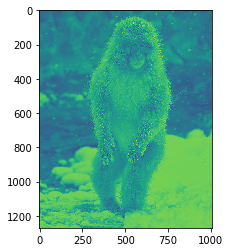

In [15]:
plt.imshow(result1)

### unroll kernal

In [45]:
def unroll_kernel(kernel, n, sparse=True):

    m = kernel.shape[0]
    if sparse:
         unrolled_K = lil_matrix(((n - m)**2, n**2))
    else:
         unrolled_K = np.zeros(((n - m)**2, n**2))

    skipped = 0
    for i in range(n ** 2):
         if (i % n) < n - m and((i / n) % n) < n - m:
             for j in range(m):
                 for l in range(m):
                    unrolled_K[i - skipped, i + j * n + l] = kernel[j, l]
         else:
             skipped += 1
    return unrolled_K

In [46]:
input_np = monkey.astype("float32").reshape(-1,1)

In [47]:
input_np

array([[ 41.],
       [ 44.],
       [ 48.],
       ...,
       [242.],
       [243.],
       [244.]], dtype=float32)

In [52]:
kernal_np = np.array([1,-1,1,0,-1,0,0,1,0]).astype("float32").reshape(3,3)

In [53]:
kernal_np 

array([[ 1., -1.,  1.],
       [ 0., -1.,  0.],
       [ 0.,  1.,  0.]], dtype=float32)

In [55]:
help(toeplitz)

Help on function toeplitz in module scipy.linalg.special_matrices:

toeplitz(c, r=None)
    Construct a Toeplitz matrix.
    
    The Toeplitz matrix has constant diagonals, with c as its first column
    and r as its first row.  If r is not given, ``r == conjugate(c)`` is
    assumed.
    
    Parameters
    ----------
    c : array_like
        First column of the matrix.  Whatever the actual shape of `c`, it
        will be converted to a 1-D array.
    r : array_like, optional
        First row of the matrix. If None, ``r = conjugate(c)`` is assumed;
        in this case, if c[0] is real, the result is a Hermitian matrix.
        r[0] is ignored; the first row of the returned matrix is
        ``[c[0], r[1:]]``.  Whatever the actual shape of `r`, it will be
        converted to a 1-D array.
    
    Returns
    -------
    A : (len(c), len(r)) ndarray
        The Toeplitz matrix. Dtype is the same as ``(c[0] + r[0]).dtype``.
    
    See Also
    --------
    circulant : circulant 

In [90]:
print(toeplitz([1,-1,1,0,0,-1,0,0,0,1,0,0,0,0,0,0]))

[[ 1 -1  1  0  0 -1  0  0  0  1  0  0  0  0  0  0]
 [-1  1 -1  1  0  0 -1  0  0  0  1  0  0  0  0  0]
 [ 1 -1  1 -1  1  0  0 -1  0  0  0  1  0  0  0  0]
 [ 0  1 -1  1 -1  1  0  0 -1  0  0  0  1  0  0  0]
 [ 0  0  1 -1  1 -1  1  0  0 -1  0  0  0  1  0  0]
 [-1  0  0  1 -1  1 -1  1  0  0 -1  0  0  0  1  0]
 [ 0 -1  0  0  1 -1  1 -1  1  0  0 -1  0  0  0  1]
 [ 0  0 -1  0  0  1 -1  1 -1  1  0  0 -1  0  0  0]
 [ 0  0  0 -1  0  0  1 -1  1 -1  1  0  0 -1  0  0]
 [ 1  0  0  0 -1  0  0  1 -1  1 -1  1  0  0 -1  0]
 [ 0  1  0  0  0 -1  0  0  1 -1  1 -1  1  0  0 -1]
 [ 0  0  1  0  0  0 -1  0  0  1 -1  1 -1  1  0  0]
 [ 0  0  0  1  0  0  0 -1  0  0  1 -1  1 -1  1  0]
 [ 0  0  0  0  1  0  0  0 -1  0  0  1 -1  1 -1  1]
 [ 0  0  0  0  0  1  0  0  0 -1  0  0  1 -1  1 -1]
 [ 0  0  0  0  0  0  1  0  0  0 -1  0  0  1 -1  1]]


In [83]:
print(toeplitz([1,2,3,4,0,0,0,0,0]))

[[1 2 3 4 0 0 0 0 0]
 [2 1 2 3 4 0 0 0 0]
 [3 2 1 2 3 4 0 0 0]
 [4 3 2 1 2 3 4 0 0]
 [0 4 3 2 1 2 3 4 0]
 [0 0 4 3 2 1 2 3 4]
 [0 0 0 4 3 2 1 2 3]
 [0 0 0 0 4 3 2 1 2]
 [0 0 0 0 0 4 3 2 1]]


In [86]:
sparse_kernal_np = np.array([
    [1,-1,1,0,0,-1,0,0,0,1,0,0,0,0,0,0],
    [0,1,-1,1,0,0,-1,0,0,0,1,0,0,0,0,0],
    [0,0,0,0,1,-1,1,0,0,-1,0,0,0,1,0,0],
    [0,0,0,0,0,1,-1,1,0,0,-1,0,0,0,1,0]
]).astype("float32")
sparse_kernal_np.shape

(4, 16)

In [31]:
result = np.dot(sparse_kernal_np,input_np)
result

ValueError: shapes (4,16) and (1280904,1) not aligned: 16 (dim 1) != 1280904 (dim 0)

In [241]:
np.dot(sparse_kernal_np.T,result).reshape([4,4])

array([[ 5.,  1., -1.,  6.],
       [ 9., -4., -7., 10.],
       [ 0., -4., -4.,  0.],
       [ 0.,  9., 10.,  0.]], dtype=float32)

### tf.nn.conv2d

In [32]:
input_tf = tf.constant(input_np,shape=[1,1272,1007,1])
input_tf[0,:,:,0]

<tf.Tensor: shape=(1272, 1007), dtype=float32, numpy=
array([[ 41.,  44.,  48., ...,  53.,  54.,  54.],
       [ 40.,  43.,  46., ...,  54.,  54.,  53.],
       [ 38.,  40.,  43., ...,  54.,  53.,  52.],
       ...,
       [229., 232., 237., ..., 241., 242., 243.],
       [234., 234., 236., ..., 241., 242., 243.],
       [235., 234., 234., ..., 242., 243., 244.]], dtype=float32)>

In [33]:
kernal_tf = tf.constant(kernal_np,shape=[3,3,1,1])

In [54]:
value = tf.nn.conv2d(input_tf, kernal_tf, strides=[1, 1, 1, 1], padding='VALID')
value[0,:,:,0]

<tf.Tensor: shape=(1270, 1005), dtype=float32, numpy=
array([[ 42.,  42.,  46., ...,  55.,  54.,  52.],
       [ 41.,  43.,  45., ...,  55.,  53.,  54.],
       [ 39.,  40.,  44., ...,  55.,  53.,  53.],
       ...,
       [234., 234., 231., ..., 239., 240., 241.],
       [234., 232., 228., ..., 241., 242., 242.],
       [232., 230., 227., ..., 242., 243., 243.]], dtype=float32)>

In [37]:
result = value[0,:,:,0]

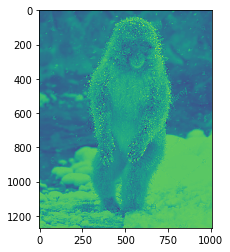

In [38]:
plt.imshow(result)

In [39]:
result = tf.nn.conv2d_transpose(value, kernal_tf, output_shape=[1,1272,1007,1], strides=[1, 1, 1, 1], padding='VALID')

In [61]:
result[0,:,:,0]

<tf.Tensor: shape=(1272, 1007), dtype=float32, numpy=
array([[ 42.,   1.,  46., ...,  52.,   2.,  52.],
       [ 41., -41.,   1., ...,   0., -51.,  53.],
       [ 39.,   2.,  42., ...,  55.,  -1.,  53.],
       ...,
       [234.,  -6., 233., ..., 243.,  -2., 243.],
       [  0.,   0.,   2., ...,   0.,  -1.,   0.],
       [  0., 234., 230., ..., 242., 243.,   0.]], dtype=float32)>

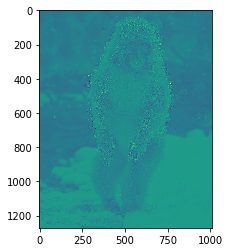

In [40]:
plt.imshow(result[0,:,:,0])

### tf.keras.layers.Conv2D

In [55]:
def kernel_init(shape, dtype=None):
    b = K.constant([[[ 1., -1.,  1.],
       [ 0., -1.,  0.],
       [ 0.,  1.,  0.]]],shape=[3,3,1,1])
    return b

In [56]:
input_tf

<tf.Tensor: shape=(1, 1272, 1007, 1), dtype=float32, numpy=
array([[[[ 41.],
         [ 44.],
         [ 48.],
         ...,
         [ 53.],
         [ 54.],
         [ 54.]],

        [[ 40.],
         [ 43.],
         [ 46.],
         ...,
         [ 54.],
         [ 54.],
         [ 53.]],

        [[ 38.],
         [ 40.],
         [ 43.],
         ...,
         [ 54.],
         [ 53.],
         [ 52.]],

        ...,

        [[229.],
         [232.],
         [237.],
         ...,
         [241.],
         [242.],
         [243.]],

        [[234.],
         [234.],
         [236.],
         ...,
         [241.],
         [242.],
         [243.]],

        [[235.],
         [234.],
         [234.],
         ...,
         [242.],
         [243.],
         [244.]]]], dtype=float32)>

In [65]:
conv1 = tf.keras.layers.Conv2D(filters=1,kernel_size=3,strides=(1,1),padding='valid',kernel_initializer=kernel_init)(input_tf)
conv2 = tf.keras.layers.Conv2D(filters=1,kernel_size=3,strides=(1,1),padding='valid',kernel_initializer=kernel_init)(conv1)
conv3 = tf.keras.layers.Conv2D(filters=1,kernel_size=3,strides=(1,1),padding='valid',kernel_initializer=kernel_init)(conv2)
conv4 = tf.keras.layers.Conv2D(filters=1,kernel_size=3,strides=(1,1),padding='valid',kernel_initializer=kernel_init)(conv3)
conv5 = tf.keras.layers.Conv2D(filters=1,kernel_size=3,strides=(1,1),padding='valid',kernel_initializer=kernel_init)(conv4)
conv5[0,:,:,0]

<tf.Tensor: shape=(1262, 997), dtype=float32, numpy=
array([[  38.,   28.,  124., ...,  146.,  -87.,  143.],
       [ 191., -185.,  387., ...,   46.,  167.,  -29.],
       [ 207., -257.,  314., ..., -212.,  325., -176.],
       ...,
       [ 132.,  101.,  247., ...,  130.,  304.,   30.],
       [ 259.,  348.,  257., ...,  280.,  220.,  353.],
       [ 199.,  272.,   33., ...,  334.,   -1.,  519.]], dtype=float32)>

True

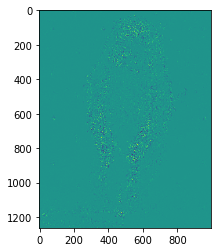

In [70]:
plt.imshow(conv5[0,:,:,0])
cv2.imwrite("monkey_conv1.jpg",conv1[0,:,:,0].numpy())
cv2.imwrite("monkey_conv2.jpg",conv2[0,:,:,0].numpy())
cv2.imwrite("monkey_conv3.jpg",conv3[0,:,:,0].numpy())
cv2.imwrite("monkey_conv4.jpg",conv4[0,:,:,0].numpy())
cv2.imwrite("monkey_conv5.jpg",conv5[0,:,:,0].numpy())

In [71]:
conv_t4 = tf.keras.layers.Conv2DTranspose(filters=1,kernel_size=3,strides=(1,1),padding='valid',kernel_initializer=kernel_init)(conv5)
conv_t3 = tf.keras.layers.Conv2DTranspose(filters=1,kernel_size=3,strides=(1,1),padding='valid',kernel_initializer=kernel_init)(conv_t4)
conv_t2 = tf.keras.layers.Conv2DTranspose(filters=1,kernel_size=3,strides=(1,1),padding='valid',kernel_initializer=kernel_init)(conv_t3)
conv_t1 = tf.keras.layers.Conv2DTranspose(filters=1,kernel_size=3,strides=(1,1),padding='valid',kernel_initializer=kernel_init)(conv_t2)
cv2.imwrite("monkey_convt1.jpg",conv_t1[0,:,:,0].numpy())
cv2.imwrite("monkey_convt2.jpg",conv_t2[0,:,:,0].numpy())
cv2.imwrite("monkey_convt3.jpg",conv_t3[0,:,:,0].numpy())
cv2.imwrite("monkey_convt4.jpg",conv_t4[0,:,:,0].numpy())

True

In [72]:
conv_t4[0,:,:,0].numpy

<bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(1264, 999), dtype=float32, numpy=
array([[  38.,  -10.,  134., ...,  376., -230.,  143.],
       [ 191., -414.,  735., ...,  -63.,   53.,  -29.],
       [ 207., -617.,  991., ..., -967.,  673., -176.],
       ...,
       [ 199.,  -54., -287., ...,  938., -843.,  519.],
       [   0.,   60.,   76., ...,  221., -166.,    0.],
       [   0.,  199.,  272., ...,   -1.,  519.,    0.]], dtype=float32)>>